In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

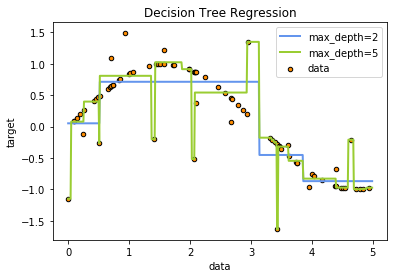

In [3]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
class CART:
    def __init__ (self, max_depth)

In [2]:
from sklearn.tree import DecisionTreeRegressor


In [3]:
import pandas as pd

In [4]:
all_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
                   delim_whitespace = True, header=None,
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                            'model', 'origin', 'car_name'])
all_data = all_data.dropna ()

In [5]:
all_data.head ()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [6]:
y = np.array (all_data['mpg'])

In [7]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                            'model', 'origin']
X = np.array (all_data[columns])

In [8]:
X

array([[   8. ,  307. ,  130. , ...,   12. ,   70. ,    1. ],
       [   8. ,  350. ,  165. , ...,   11.5,   70. ,    1. ],
       [   8. ,  318. ,  150. , ...,   11. ,   70. ,    1. ],
       ..., 
       [   4. ,  135. ,   84. , ...,   11.6,   82. ,    1. ],
       [   4. ,  120. ,   79. , ...,   18.6,   82. ,    1. ],
       [   4. ,  119. ,   82. , ...,   19.4,   82. ,    1. ]])

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
class boost:
    def __init__ (self, T=10, gd_iterarions=1000, gd_lr=0.00005):
        self.T=T
        self.a = []
        self.b = []
        self.gd_iterarions = gd_iterarions
        self.gd_lr = gd_lr
        
    def gd (self, df):
        point = 1
        for i in range(self.gd_iterarions):
            grad = df (point)
            point = point - self.gd_lr * grad
            if abs (self.gd_lr * grad) < 1e-10:
                break
        return point
        
    def fit (self, X, y):
        h = np.zeros (y.shape)
        h = np.median (y) #1. init array h0
        g = np.zeros (y.shape)
        for i in range (self.T):
            g = np.sign (y - h)
            a_i = DecisionTreeRegressor(criterion='mse', max_depth=3)
            a_i.fit (X, -g)
            self.a.append (a_i)
            res = a_i.predict (X)
#             df = lambda x: np.sum (res * np.sign (y - (h + x * res)))
#             b_i = self.gd (df)
            b_i = 1 * self.gd_lr ** (i / 100.)
            self.b.append (b_i)
            h = h + b_i * h
#             print "b is:", b_i
    
    def predict (self, X):
        res = self.b[0] * self.a[0].predict (X)
        for i in range(1, len(self.a)):
            res += self.b[i] * self.a[i].predict (X)
        return res

In [35]:
err_train = []
err_test = []
for i in range (1, 50):
    boo = boost (T=i, gd_lr=0.1, gd_iterarions=15)
    boo.fit (X_train, y_train)
    if i % 50 == 0:
        print i
    err_train.append (np.linalg.norm (boo.predict (X_train) - y_train, ord=1))
    err_test.append (np.linalg.norm (boo.predict (X_test) - y_test, ord=1))

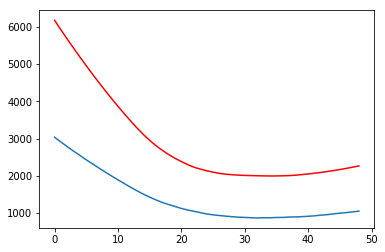

In [36]:
plt.plot (err_train, c='r')
plt.plot (err_test)
plt.show ()

In [344]:
b = 3

for i in range (1000):
#     u_1 = abs (5 - (3 + b*2))
#     u_2 = abs (-4 - (2 + b*(-3)))
#     u = u_1 + u_2
    d_1 = (2 * np.sign (5 - (3 + b*2)))
    d_2 = (-3 * np.sign (-4 - (2 + b*(-3))))
    d = d_1 + d_2
    if abs(u)<1e-15:
        u=0
    if abs(d) < 1e-15:
        d = 1
#     print u_1, u_2, d
#     b = b + u/d
    print d_1, d_2
    b = b + 0.01 * d
    print b
    print

-2 -3
2.95

-2.0 -3.0
2.9

-2.0 -3.0
2.85

-2.0 -3.0
2.8

-2.0 -3.0
2.75

-2.0 -3.0
2.7

-2.0 -3.0
2.65

-2.0 -3.0
2.6

-2.0 -3.0
2.55

-2.0 -3.0
2.5

-2.0 -3.0
2.45

-2.0 -3.0
2.4

-2.0 -3.0
2.35

-2.0 -3.0
2.3

-2.0 -3.0
2.25

-2.0 -3.0
2.2

-2.0 -3.0
2.15

-2.0 -3.0
2.1

-2.0 -3.0
2.05

-2.0 -3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2.0

-2.0 -3.0
1.95

-2.0 3.0
1.96

-2.0 3.0
1.97

-2.0 3.0
1.98

-2.0 3.0
1.99

-2.0 3.0
2

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# @jit
def _find_best_split_feature(argsort_x, feature_num, feature_val, min_error, num, sorted_y, tmp, values_list,
                             x):
    l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum = _init_sums(sorted_y, values_list)
    for val_num in values_list:
        err = _get_mse(r_sum, r_sq_sum, r_size) + _get_mse(l_sum, l_sq_sum, l_size)

        l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum = _change_sums(l_size, l_sq_sum, l_sum, r_size,
                                                                        r_sq_sum, r_sum, sorted_y[val_num])
        if not min_error or min_error > err:
            feature_num = num
            feature_val = x[argsort_x[val_num, num], num]
            tmp = val_num
            min_error = err
    return feature_num, feature_val, min_error, tmp


# @jit
def _init_sums(sorted_y, values_list):
    r_size = sorted_y[:values_list[0]].size
    l_size = sorted_y[values_list[0]:].size
    r_sum = sorted_y[:values_list[0]].sum()
    l_sum = sorted_y[values_list[0]:].sum()
    r_sq_sum = (sorted_y[:values_list[0]] ** 2).sum()
    l_sq_sum = (sorted_y[values_list[0]:] ** 2).sum()
    return l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum


# @jit
def _change_sums(l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum, changing_val):
    r_sum += changing_val
    l_sum -= changing_val
    r_sq_sum += changing_val * changing_val
    l_sq_sum -= changing_val * changing_val
    r_size += 1
    l_size -= 1
    return l_size, l_sq_sum, l_sum, r_size, r_sq_sum, r_sum


# @jit
def _get_mse(el_sum, sq_sum,  num):
    res = (sq_sum - (el_sum * el_sum) / num) / num
    if res < 0:
        raise 1
    return res


# @jit
def load_data():
    all_data = pd.read_csv("auto-mpg.data",
                           delim_whitespace=True, header=None,
                           names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                                  'model', 'origin', 'car_name'])
    all_data = all_data.dropna()
    y = np.array(all_data['mpg'])
    columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
               'model', 'origin']
    X = np.array(all_data[columns])
    return X, y


class MyDecisionTreeRegressor:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def __find_threshold(self, x, y):
        argsort_x = x.argsort(axis=0)

        min_error = None
        feature_num = None
        feature_val = None
        tmp = None

        values_list = range(self.min_samples_split, x.shape[0] - self.min_samples_split)
        if len(values_list) == 0:
            return None

        for num in range(x.shape[1]):
            sorted_y = y[argsort_x[:, num]]

            feature_num, feature_val, min_error, tmp = _find_best_split_feature(argsort_x, feature_num,
                                                                                feature_val, min_error, num,
                                                                                sorted_y, tmp, values_list, x)

        if min_error is None:
            raise 1

        return feature_num, feature_val, \
               x[argsort_x[:, feature_num]][:tmp], \
               x[argsort_x[:, feature_num]][tmp:], \
               y[argsort_x[:, feature_num]][:tmp], \
               y[argsort_x[:, feature_num]][tmp:]

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        if self.max_depth is not None and depth == self.max_depth:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return x,y
        if self.min_samples_split is not None and x.shape[0] <= self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return

        res = self.__find_threshold(x, y)
        if res is None:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return

        feature_num, feature_val, x_l, x_r, y_l, y_r = res

        if y_l.size < self.min_samples_split or y_r.size < self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return

        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_num, feature_val)
        return self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1),  self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        return self.__fit_node(x, y, 0, 0)

    def __predict(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_num, feature_val = node
            if x[feature_num] < feature_val:
                return self.__predict(x, 2 * node_id + 1)
            else:
                return self.__predict(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        return np.array([self.__predict(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [3]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

err = []
test_err = []
i = 1

tree = MyDecisionTreeRegressor(max_depth=i)
res = tree.fit(X_train, y_train)
tree_l = MyDecisionTreeRegressor(max_depth=i)
tree_r = MyDecisionTreeRegressor(max_depth=i)

In [4]:
res

((array([[   3. ,   70. ,  100. , ...,   12.5,   80. ,    3. ],
         [   3. ,   70. ,   97. , ...,   13.5,   72. ,    3. ],
         [   4. ,   71. ,   65. , ...,   19. ,   71. ,    3. ],
         ..., 
         [   6. ,  173. ,  115. , ...,   11.3,   79. ,    1. ],
         [   5. ,  183. ,   77. , ...,   20.1,   79. ,    2. ],
         [   6. ,  198. ,   95. , ...,   16. ,   73. ,    1. ]]),
  array([ 23.7,  19. ,  31. ,  32. ,  35. ,  31. ,  32.8,  31. ,  39.1,
          36. ,  30. ,  31. ,  21.5,  32. ,  39.4,  33.5,  32. ,  40.8,
          37. ,  31.8,  34.1,  46.6,  30. ,  31.5,  37.7,  38.1,  28. ,
          43.1,  44.3,  25. ,  43.4,  33. ,  37. ,  44.6,  38. ,  33. ,
          33.8,  27. ,  29.5,  34.3,  27. ,  27. ,  29. ,  32.3,  23. ,
          20. ,  28. ,  26. ,  24.5,  33.5,  32.1,  29.9,  29.5,  36. ,
          30.5,  36.1,  41.5,  35.7,  30. ,  29. ,  31.5,  27. ,  38. ,
          33. ,  30.9,  34.5,  36. ,  33.7,  32.4,  28. ,  24. ,  32.2,
          26. ,  34. , 

In [ ]:
def tree_test():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    err = []
    test_err = []
    for i in range(1,2):
        tree = MyDecisionTreeRegressor(max_depth=i)
        res = tree.fit(X_train, y_train)
        tree_l = MyDecisionTreeRegressor(max_depth=i)
        tree_r = MyDecisionTreeRegressor(max_depth=i)
        
        tree

        err.append(np.linalg.norm(tree.predict(X_test) - y_test))

        test_tree = DecisionTreeRegressor(max_depth=i, criterion='mse')
        test_tree.fit(X_train, y_train)
        test_err.append(np.linalg.norm(test_tree.predict(X_test) - y_test))

    print err
    print
    print test_err
    plt.plot(err, label='my')
    plt.plot(test_err, label='test')
    plt.show()


tree_test()